Tensorflow hub is a platform for transfer learning and for sharing pre-trained model components.

In [0]:
#!pip install -q tf-nightly tf-hub-nightly tfds-nightly

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200205
GPU is available.


# An Image Classifier

## Download the Classifier from TF.Hub

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [0]:
IMAGE_SHAPE = (224, 224)

def classifier(inputs):
  cls = hub.KerasLayer(classifier_url)(inputs)
  return cls

inputs = tf.keras.Input(shape=IMAGE_SHAPE + (3,))
outputs = classifier(inputs)
cls_model = tf.keras.Model(inputs, outputs)

## Run the Inference

Run an image on the model.

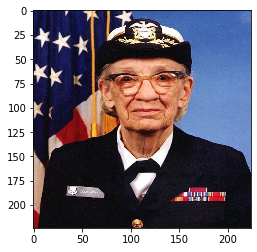

In [11]:
image_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg'

path = tf.keras.utils.get_file('image.jpg', origin=image_url)
img = cv2.imread(path)
img = cv2.resize(img, IMAGE_SHAPE)
img = img[:,:,::-1]

plt.imshow(img)
plt.show()

Normalize the image.

In [12]:
img = img / 255.0
img = img[np.newaxis, ...]
img.shape

(1, 224, 224, 3)

Predict the image.

In [15]:
cls_res = cls_model.predict(img)
cls_res.shape, tf.reduce_sum(cls_res)

((1, 1001), <tf.Tensor: shape=(), dtype=float32, numpy=-15.500399>)

The prediction is a vector representing the logits of each category.

In [18]:
np.argmax(cls_res[0], axis=-1)

653

## Decode the Prediction

In [19]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels = np.array(open(labels_path).read().splitlines())
labels.shape

16384/10484 [==============================================] - 0s 1us/step


(1001,)

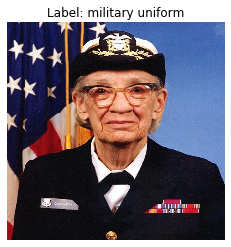

In [21]:
plt.imshow(np.squeeze(img, axis=0))
plt.axis("off")
plt.title('Label: {}'.format(labels[np.argmax(cls_res[0], axis=-1)]))
plt.show()

# Transfer Learning

It is simple to retrain the model on our datasets using TF.Hub.

## Datasets

In [22]:
data_root = tf.keras.utils.get_file(
  'flower_photos', origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
  untar=True)
data_root

228818944/228813984 [==============================] - 4s 0us/step


'/root/.keras/datasets/flower_photos'

In [23]:
!ls -al {data_root}

total 620
drwxr-x--- 7 270850 5000   4096 Feb 10  2016 .
drwxr-xr-x 3 root   root   4096 Feb  6 09:15 ..
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy
drwx------ 2 270850 5000  49152 Feb 10  2016 dandelion
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  45056 Feb 10  2016 tulips


Normalize the image datasets and load the datasets with a generator.

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [28]:
image_data = image_generator.flow_from_directory(
  directory=data_root, target_size=IMAGE_SHAPE, class_mode='categorical', batch_size=32, shuffle=True
)

Found 3670 images belonging to 5 classes.


In [29]:
for image_batch, label_batch in image_data:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 224, 224, 3)
(32, 5)


Run a batch of images on the classifier.

In [34]:
batch_res = cls_model.predict(image_batch)
predicted_names = labels[np.argmax(batch_res, axis=1)]
predicted_names

array(['daisy', 'goose', 'daisy', 'daisy', 'conch', 'picket fence',
       'daisy', 'picket fence', 'hip', 'rapeseed', 'vase', 'bee',
       'picket fence', 'ant', 'rapeseed', 'vase', 'daisy', 'cardoon',
       'sulphur butterfly', 'cardoon', 'daisy', 'vase', 'hay', 'daisy',
       'lab coat', 'sea urchin', 'daisy', 'daisy', 'velvet', 'daisy',
       'picket fence', 'sea anemone'], dtype='<U30')

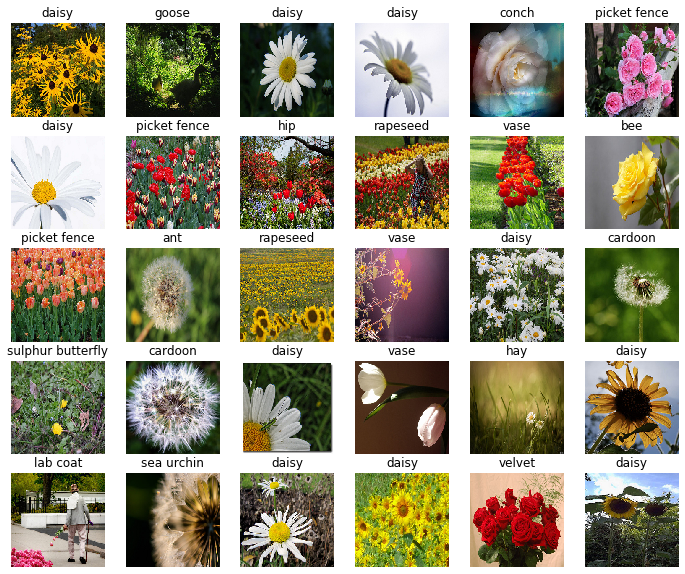

In [35]:
plt.figure(figsize=(12, 10))
for i in range(30):
  plt.subplot(5, 6, i+1)
  plt.imshow(image_batch[i])
  plt.axis("off")
  plt.title(predicted_names[i])
plt.show()

## Headless Model

Tensorflow Hub also provides a headless model without the top classification layer. These models help transfer learning.

Any **image feature vector** model is suitable for the task.

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url)

In [38]:
features = feature_extractor_layer(image_batch)
features.shape

TensorShape([32, 1280])

The feature extraction layer returns a 1280-size vector for each image.

In [0]:
feature_extractor_layer.trainable = False

Here we freeze the feature extraction model's weights in order not to train its weights. We can train the attaching dense layer only to do the transfer learning.

## Attach the Classification Layer

In [0]:
def build_classification_model(inputs):
  x = feature_extractor_layer(inputs)
  cls_output = layers.Dense(units=5, activation='softmax')(x)
  return cls_output

inputs = tf.keras.Input(shape=IMAGE_SHAPE + (3,))
outputs = build_classification_model(inputs)
new_cls_model = tf.keras.Model(inputs, outputs)

In [41]:
new_cls_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


Let's try the inference.

In [43]:
new_cls_model.predict(image_batch).shape

(32, 5)

## Train the Model

In [0]:
new_cls_model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(),
  metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

To monitor the training process in each batch instead of epoch average, we save the loss and the accuracy of every batch using a callback function.

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    super(CollectBatchStats, self).__init__()
    self.batch_losses = []
    self.batch_accuracy = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_accuracy.append(logs['categorical_accuracy'])
    self.model.reset_metrics()

In [48]:
steps_per_epoch = image_data.samples // image_data.batch_size

batch_stats_callback = CollectBatchStats()

history = new_cls_model.fit_generator(
  image_data, epochs=2, steps_per_epoch=steps_per_epoch, 
  callbacks=[batch_stats_callback])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 114 steps
Epoch 1/2
114/114 [==============================] - 13s 117ms/step - loss: 0.6531 - categorical_accuracy: 0.9062
Epoch 2/2
114/114 [==============================] - 13s 115ms/step - loss: 0.3305 - categorical_accuracy: 0.9062


In [49]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy'])

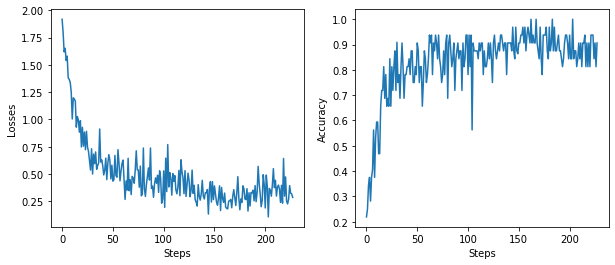

In [51]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(batch_stats_callback.batch_losses)
plt.xlabel("Steps")
plt.ylabel("Losses")

plt.subplot(1, 2, 2)
plt.plot(batch_stats_callback.batch_accuracy)
plt.xlabel("Steps")
plt.ylabel("Accuracy")

plt.show()

## Make Predictions

In [60]:
cls_dict = image_data.class_indices.items()
sorted_pairs = sorted(cls_dict, key=lambda pair: pair[1])
class_names = np.array([pair[0] for pair in sorted_pairs])
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [62]:
predicted_res = new_cls_model.predict(image_batch)
predicted_id = np.argmax(predicted_res, axis=-1)
predicted_label_names = class_names[predicted_id]
predicted_label_names

array(['sunflowers', 'roses', 'daisy', 'daisy', 'roses', 'roses', 'daisy',
       'tulips', 'tulips', 'tulips', 'tulips', 'roses', 'tulips',
       'dandelion', 'sunflowers', 'sunflowers', 'daisy', 'dandelion',
       'daisy', 'dandelion', 'daisy', 'tulips', 'dandelion', 'sunflowers',
       'tulips', 'dandelion', 'daisy', 'sunflowers', 'roses',
       'sunflowers', 'tulips', 'dandelion'], dtype='<U10')

In [0]:
label_id = np.argmax(label_batch, axis=-1)

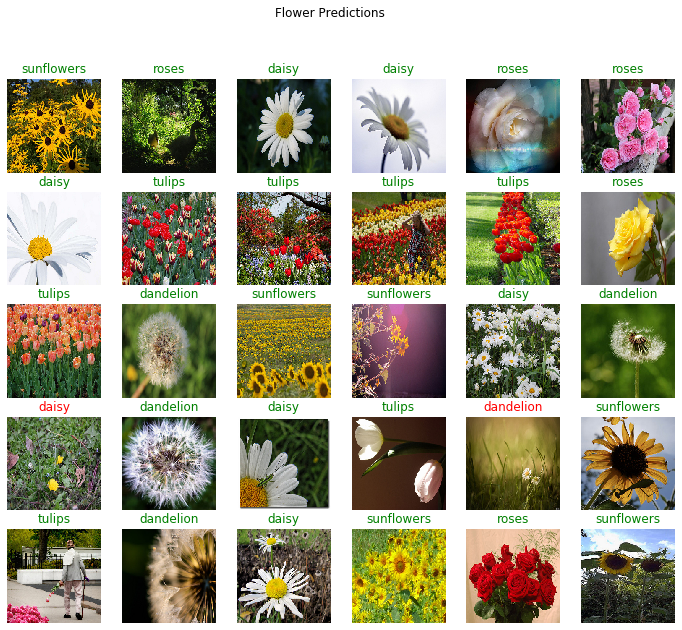

In [67]:
plt.figure(figsize=(12, 10))
for i in range(30):
  plt.subplot(5, 6, i+1)
  plt.imshow(image_batch[i])
  plt.axis("off")
  color = "green" if label_id[i] == predicted_id[i] else "red"
  plt.title(predicted_label_names[i], color=color)
plt.suptitle("Flower Predictions")
plt.show()

# Export the Model

In [0]:
import time

In [69]:
export_path = "/tmp/saved_models/{}".format(int(time.time()))
new_cls_model.save(export_path, save_format="tf")

export_path

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1580984410/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1580984410/assets


'/tmp/saved_models/1580984410'

# Re-import the Model

In [0]:
loaded = tf.keras.models.load_model(export_path)

Confirm the result predicted by two models is the same.

In [0]:
loaded_res = loaded.predict(image_batch)
preicted_res = new_cls_model(image_batch)

In [73]:
abs(loaded_res - predicted_res).sum()

0.0